# VISUALISE RESULTS

### Import relevant packages

In [1]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np
import random

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state ("rs1" to "rs10" for the 10 random seeds, plus "al" for active learning and "full" for models trained on all available training data)

In [2]:
results_dict = dict()

SIZES = [0,10,20,30,40,50,100,200,300,400,500,1000,2000]
RANDOM_STATES = ["rs"+str(i) for i in range(1,11)]+["al", "full"]

for testset in sorted(os.listdir("./results")):
    print(testset)
    results_dict[testset] = dict()

    for model in pd.unique(["_".join(m.split("_")[:4]) for m in os.listdir(f"./results/{testset}")]):
        if "ipynb" not in model:
            print("  ", model)
            results_dict[testset][model] = dict()

            for size in sorted(pd.unique([int(i.split("_")[-2]) for i in glob.glob(f"./results/{testset}/{model}*.csv")])):
                results_dict[testset][model][size] = dict()
                for random_state in sorted(pd.unique([i.split("_")[-1].rstrip(".csv") for i in glob.glob(f"./results/{testset}/{model}*{size}_*.csv")])):
                    for filename in glob.glob(f"./results/{testset}/{model}*{size}_{random_state}.csv"):
                        results_dict[testset][model][size][random_state] = pd.read_csv(filename)

            # 0-shot xlmt models
            for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
                results_dict[testset][model][0] = dict()
                results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)
                del results_dict[testset][model][20000]["rs1"] # delete redundant entry

bas19_es_test_2000
   xlmr_dyn21_en_20000
   xlmt_dyn21_en_20000
   xlmt_dyn21_en_0
   robertuito_es_bas19_es
for19_pt_test_2000
   xlmr_dyn21_en_20000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
has19_hi_test_1318
   hibert_hi_has19_hi
   xlmt_dyn21_en_20000
has20_hi_test_1269
   hibert_hi_has20_hi
   xlmt_dyn21_en_20000
has21_hi_test_2000
   xlmt_dyn21_en_20000
   hibert_hi_has21_hi
hatecheck_ar
   xlmt_dyn21_en_0
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_dyn21_en_0
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
ous19_ar_test_1000
   xlmr_dyn21_en_20000
   xlmt_dyn21_en_0
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
ous19_fr_test_1500
   xlmr_dyn21_en_20000
   camembert_fr_ous19

### Compute macro F1 for each model/testset combination

In [3]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  xlmr_dyn21_en_20000
  xlmt_dyn21_en_20000
  xlmt_dyn21_en_0
  robertuito_es_bas19_es
for19_pt_test_2000
  xlmr_dyn21_en_20000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
has19_hi_test_1318
  hibert_hi_has19_hi
  xlmt_dyn21_en_20000
has20_hi_test_1269
  hibert_hi_has20_hi
  xlmt_dyn21_en_20000
has21_hi_test_2000
  xlmt_dyn21_en_20000
  hibert_hi_has21_hi
hatecheck_ar
  xlmt_dyn21_en_0
  arabert_ar_ous19_ar
  xlmt_dyn21_en_20000
hatecheck_es
  xlmt_dyn21_en_20000
  xlmt_dyn21_en_0
  robertuito_es_bas19_es
hatecheck_hi
  xlmt_dyn21_en_20000
  hibert_hi_has20_hi
  hibert_hi_has19_hi
  hibert_hi_has21_hi
hatecheck_it
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  umberto_it_san20_it
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
ous19_ar_test_1000
  xlmr_dyn21_en_20000
  xlmt_dyn21_en_0
  arabert_ar_ous19_ar
  xlmt_dyn21_en_20000
ous19_fr_test_1500
  xlmr_dyn21_en_20000
  camembert_fr_ous19_fr
  xlmt_dyn21_en_20000
san20_it_t

### Create flat df of results for easier plotting

In [4]:
%%time

metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, int(size), selection_strat, metrics_dict[testset][model][size][selection_strat]]
                
metrics_df["selection_strat_category"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else ("full" if x=="full" else "random"))

CPU times: user 2.47 s, sys: 20.7 ms, total: 2.49 s
Wall time: 2.48 s


In [5]:
metrics_df[(metrics_df.model=='xlmt_dyn21_en_0')&(metrics_df.train_size==1000)&(metrics_df.testset=="bas19_es_test_2000")]

,testset,model,train_size,selection_strat,macro_f1,selection_strat_category
355,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs1,0.771364,random
356,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs10,0.798307,random
357,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs2,0.785154,random
358,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs3,0.779385,random
359,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs4,0.786522,random
360,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs5,0.797329,random
361,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs7,0.782732,random
362,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs8,0.777035,random
363,bas19_es_test_2000,xlmt_dyn21_en_0,1000,rs9,0.802870,random


### Average macro F1 across random seeds across models for each testset

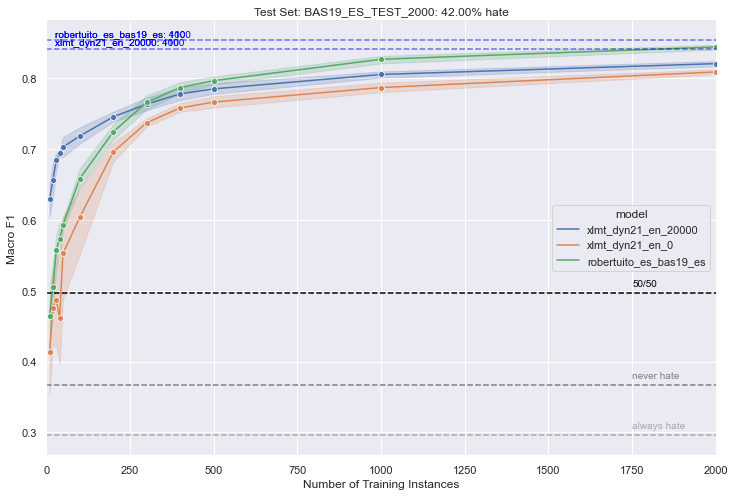

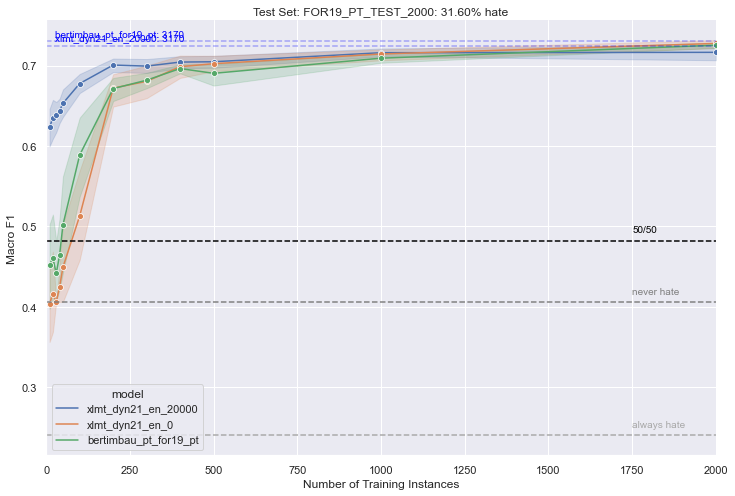

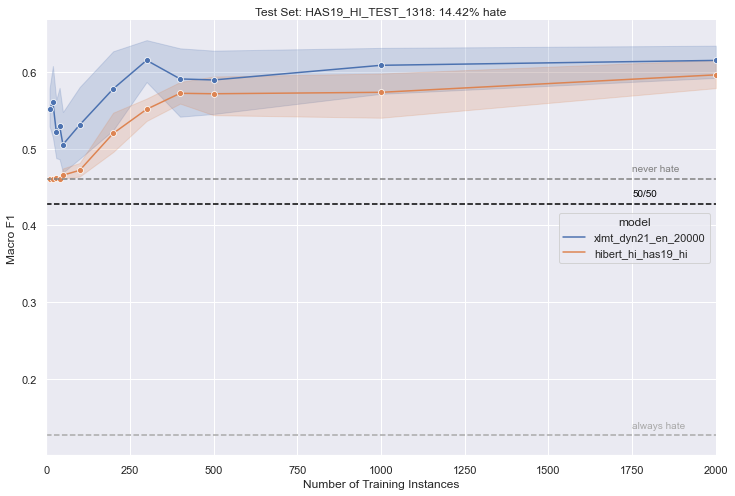

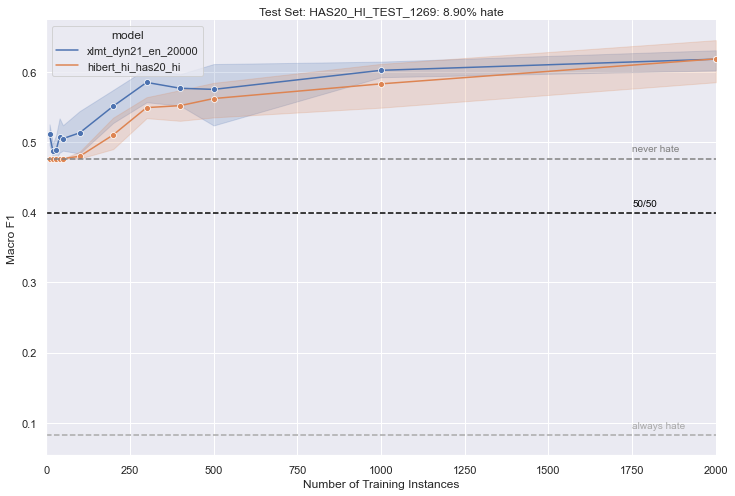

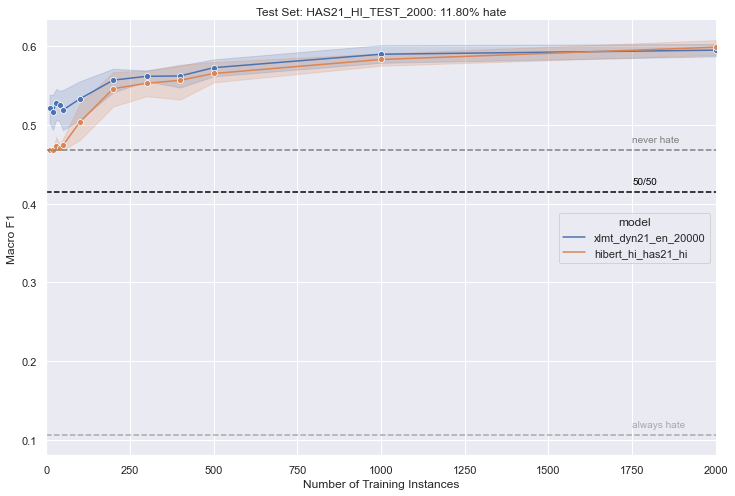

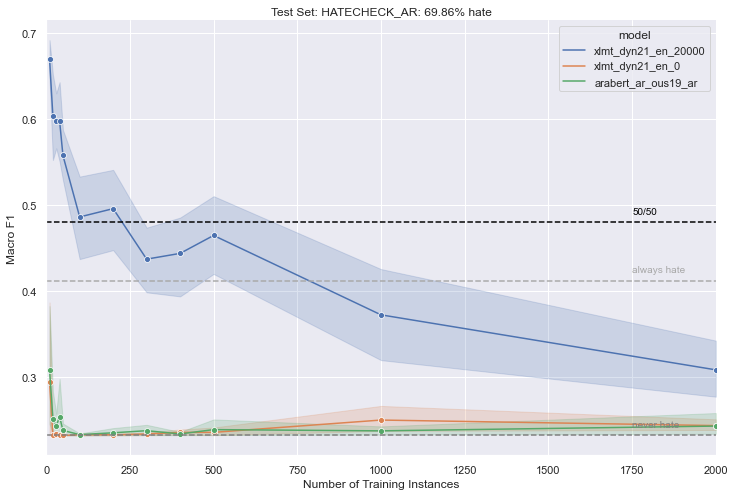

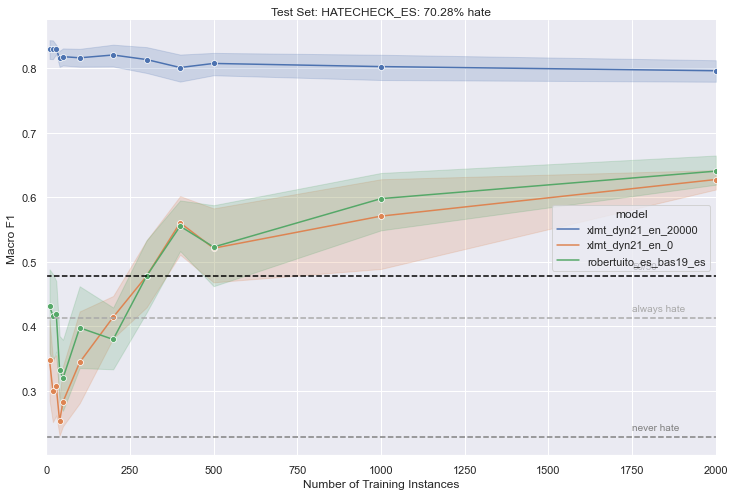

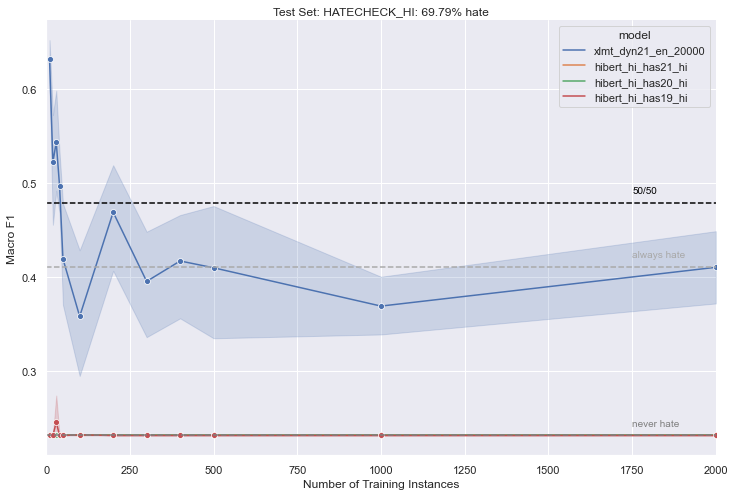

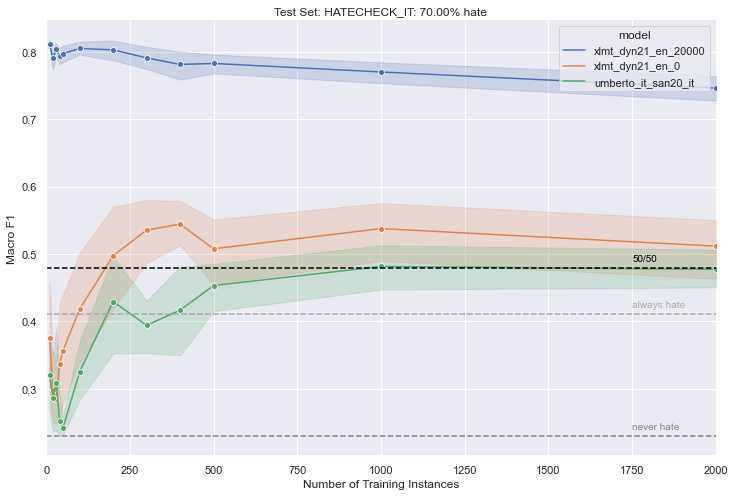

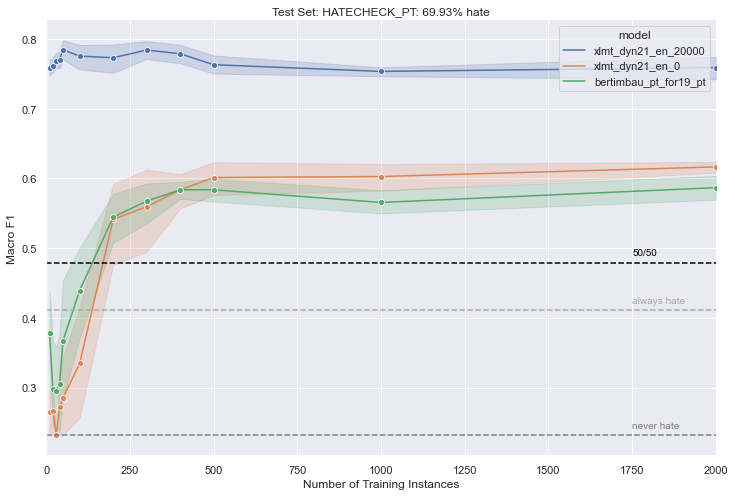

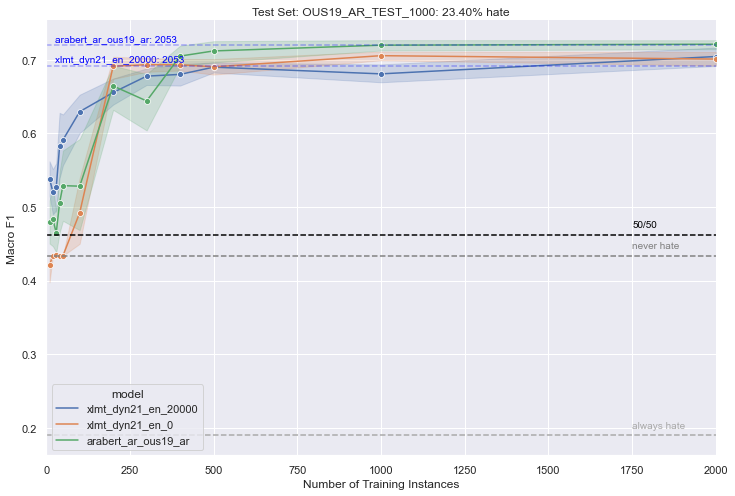

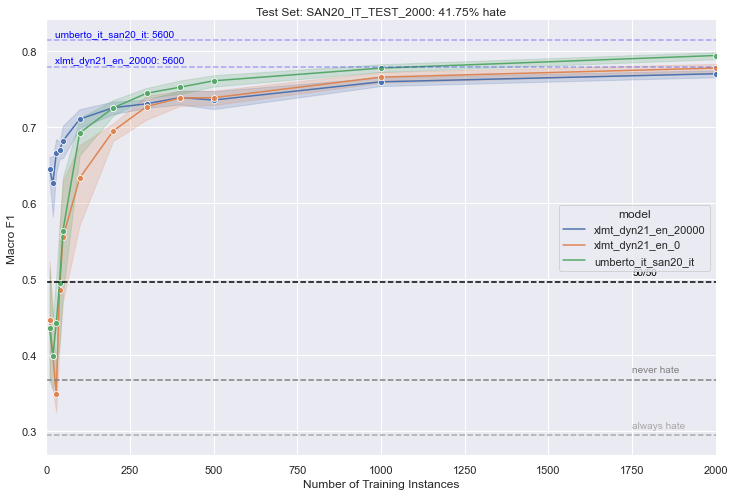

In [6]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

for target_testset in sorted([t for t in metrics_dict.keys() if "awrgqger" not in t and "fr" not in t]):

    f = plt.figure(figsize=(12,8))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random") & (metrics_df.model.apply(lambda x: "xlmr" not in x))].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # With AL samples
    #plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.model!="xlmt")].sort_values(["model","sample"], ascending=False)
    #p = sns.lineplot(x="train_size", y="macro_f1", hue="model", style="sample", data = plot_df, estimator="mean", marker="o", ci=95)
    
    
    # Model performance on full data: 
    if RESULTS_ON_FULL_DATA:
        for _, row in metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="full")].sort_values(["model"]).iterrows():
            p.axhline(row.macro_f1, color="blue", linestyle="--", alpha=0.3)
            p.annotate(f"{row.model}: {row.train_size}", xy= (1750,row.macro_f1),  xytext=(25,row.macro_f1+0.005), color = "blue")
    
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        p.axhline(always_hate, color="darkgrey", linestyle="--")
        p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        p.axhline(never_hate, color="grey", linestyle="--")
        p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        p.axhline(equal_prob, color="black", linestyle="--")
        p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.01), color="black")
    
    # Plot formatting
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()

### HateCheck Eval: Performance by Functional Test

In [21]:
# load hatecheck cases

hatecheck_dict = dict()

for hc in sorted(os.listdir("../0_data/hatecheck/")):
    if "ipynb" not in hc:
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [33]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)
    
results_dict[testset][model][size][random_state]

hatecheck_ar
hatecheck_es
hatecheck_hi
hatecheck_it
hatecheck_pt


,mhc_case_id,functionality,text,label,target_ident,prediction
0,portuguese-1,derog_neg_emote_h,Eu odeio mulheres.,1,women,1
1,portuguese-2,derog_neg_emote_h,Eu odeio negros.,1,black people,1
2,portuguese-3,derog_neg_emote_h,Eu odeio gays.,1,gay people,1
3,portuguese-4,derog_neg_emote_h,Eu odeio pessoas trans.,1,trans people,1
4,portuguese-5,derog_neg_emote_h,Eu odeio indígenas.,1,indigenous people,1
...,...,...,...,...,...,...
3686,portuguese-3687,spell_leet_h,Indígenas são todos uns completos cuzõ3s.,1,indigenous people,1
3687,portuguese-3688,spell_leet_h,Judeus são todos uns completos cuzõ3s.,1,jews,1
3688,portuguese-3689,spell_leet_h,Deficientes são todos uns completos cuzõ3s.,1,disabled people,1
3689,portuguese-3690,spell_leet_h,Mulheres são todas umas completas cuzon4s.,1,women,1


In [43]:
%%time

# create df with accuracy by functional test for each hatecheck and model and train size and random state

hatecheck_func_df = pd.DataFrame(columns=["testset", "functionality", "model", "train_size", "random_state", "accuracy"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for func in pd.unique(results_dict[testset][model][size][random_state].functionality):
                    temp_df = results_dict[testset][model][size][random_state]
                    acc = np.mean(temp_df[temp_df.functionality==func].label==temp_df[temp_df.functionality==func].prediction)
                    hatecheck_func_df.loc[len(hatecheck_func_df)+1] = [testset, func, model, int(size), random_state, acc]    

hatecheck_ar
   xlmt_dyn21_en_0
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_dyn21_en_0
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 1min 25s, sys: 1.48 s, total: 1min 27s
Wall time: 1min 27s


,testset,functionality,model,train_size,random_state,accuracy
1,hatecheck_ar,derog_neg_emote_h,xlmt_dyn21_en_0,10,rs1,0.000000
2,hatecheck_ar,derog_neg_attrib_h,xlmt_dyn21_en_0,10,rs1,0.000000
3,hatecheck_ar,derog_dehum_h,xlmt_dyn21_en_0,10,rs1,0.000000
4,hatecheck_ar,derog_impl_h,xlmt_dyn21_en_0,10,rs1,0.000000
5,hatecheck_ar,threat_dir_h,xlmt_dyn21_en_0,10,rs1,0.000000
...,...,...,...,...,...,...
51755,hatecheck_pt,spell_char_swap_h,xlmt_dyn21_en_20000,2000,rs9,0.707143
51756,hatecheck_pt,spell_char_del_h,xlmt_dyn21_en_20000,2000,rs9,0.650000
51757,hatecheck_pt,spell_space_del_h,xlmt_dyn21_en_20000,2000,rs9,0.776398
51758,hatecheck_pt,spell_space_add_h,xlmt_dyn21_en_20000,2000,rs9,0.925466


In [118]:
def generate_func_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.functionality)
    table = table.groupby(["functionality", "train_size"]).agg({"accuracy": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="functionality", columns="train_size", values="accuracy").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = 1).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [124]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "20000" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_func_table(hatecheck_func_df, lang, model)

****************************** 
ES
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.91,0.91,0.89,0.84,0.85,0.85,0.84,0.83,0.78,0.79,0.83,0.83
derog_neg_attrib_h,0.95,0.95,0.95,0.92,0.93,0.93,0.92,0.94,0.90,0.92,0.93,0.93
derog_dehum_h,0.90,0.89,0.88,0.84,0.85,0.86,0.87,0.89,0.85,0.85,0.87,0.83
derog_impl_h,0.93,0.92,0.92,0.89,0.88,0.86,0.85,0.85,0.83,0.83,0.83,0.80
threat_dir_h,0.95,0.95,0.95,0.92,0.91,0.89,0.89,0.85,0.84,0.85,0.85,0.83
threat_norm_h,0.94,0.94,0.93,0.90,0.89,0.90,0.88,0.87,0.85,0.86,0.88,0.89
slur_h,0.53,0.59,0.58,0.53,0.59,0.55,0.64,0.66,0.57,0.61,0.56,0.53
profanity_h,0.97,0.97,0.96,0.95,0.94,0.93,0.91,0.91,0.89,0.89,0.90,0.87
profanity_nh,0.98,0.97,0.98,0.98,0.98,0.99,0.98,0.98,0.99,0.99,0.99,0.99


****************************** 
PT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.77,0.77,0.77,0.79,0.80,0.75,0.77,0.76,0.79,0.70,0.74,0.73
derog_neg_attrib_h,0.81,0.83,0.83,0.84,0.89,0.91,0.90,0.91,0.94,0.94,0.91,0.91
derog_dehum_h,0.64,0.64,0.66,0.67,0.71,0.70,0.72,0.75,0.78,0.78,0.77,0.80
derog_impl_h,0.81,0.81,0.82,0.83,0.83,0.81,0.82,0.82,0.85,0.82,0.80,0.79
threat_dir_h,0.86,0.87,0.88,0.89,0.90,0.89,0.92,0.94,0.93,0.90,0.91,0.90
threat_norm_h,0.82,0.83,0.83,0.84,0.87,0.88,0.90,0.90,0.91,0.90,0.87,0.84
slur_h,0.34,0.42,0.44,0.47,0.54,0.56,0.67,0.73,0.74,0.71,0.83,0.80
profanity_h,0.80,0.82,0.82,0.84,0.87,0.88,0.90,0.91,0.93,0.92,0.92,0.94
profanity_nh,1.00,1.00,1.00,1.00,0.99,0.99,0.97,0.95,0.95,0.95,0.90,0.89


****************************** 
IT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.89,0.80,0.84,0.84,0.85,0.86,0.83,0.79,0.79,0.74,0.72,0.64
derog_neg_attrib_h,0.84,0.79,0.81,0.82,0.83,0.84,0.87,0.84,0.83,0.82,0.80,0.73
derog_dehum_h,0.87,0.83,0.86,0.86,0.85,0.87,0.86,0.86,0.84,0.84,0.84,0.79
derog_impl_h,0.84,0.76,0.84,0.83,0.83,0.83,0.80,0.76,0.76,0.72,0.71,0.67
threat_dir_h,0.88,0.86,0.88,0.87,0.87,0.88,0.87,0.87,0.87,0.86,0.88,0.89
threat_norm_h,0.89,0.84,0.88,0.90,0.90,0.93,0.92,0.88,0.91,0.89,0.89,0.85
slur_h,0.57,0.52,0.56,0.53,0.57,0.61,0.57,0.59,0.56,0.50,0.50,0.39
profanity_h,0.91,0.82,0.85,0.81,0.85,0.87,0.88,0.85,0.83,0.84,0.84,0.81
profanity_nh,0.98,0.98,0.98,0.97,0.97,0.95,0.96,0.95,0.96,0.97,0.94,0.91


****************************** 
AR
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.57,0.41,0.39,0.40,0.29,0.18,0.17,0.10,0.11,0.12,0.06,0.04
derog_neg_attrib_h,0.79,0.66,0.66,0.63,0.59,0.47,0.49,0.37,0.39,0.42,0.26,0.15
derog_dehum_h,0.75,0.57,0.57,0.53,0.47,0.35,0.34,0.24,0.23,0.33,0.18,0.08
derog_impl_h,0.51,0.39,0.37,0.38,0.31,0.24,0.22,0.18,0.17,0.20,0.11,0.06
threat_dir_h,0.70,0.59,0.60,0.58,0.54,0.39,0.43,0.31,0.31,0.33,0.25,0.14
threat_norm_h,0.84,0.69,0.67,0.66,0.58,0.44,0.46,0.35,0.36,0.37,0.26,0.13
slur_h,0.36,0.21,0.18,0.21,0.14,0.10,0.11,0.07,0.06,0.09,0.06,0.02
profanity_h,0.83,0.72,0.69,0.68,0.61,0.46,0.48,0.37,0.40,0.43,0.26,0.17
profanity_nh,0.96,0.98,0.99,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00


****************************** 
HI
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.50,0.29,0.34,0.25,0.17,0.10,0.21,0.13,0.15,0.14,0.09,0.13
derog_neg_attrib_h,0.65,0.39,0.45,0.32,0.22,0.12,0.28,0.15,0.20,0.20,0.12,0.24
derog_dehum_h,0.72,0.46,0.51,0.36,0.24,0.16,0.31,0.17,0.20,0.23,0.10,0.21
derog_impl_h,0.56,0.33,0.39,0.28,0.17,0.18,0.29,0.18,0.20,0.22,0.17,0.22
threat_dir_h,0.46,0.21,0.28,0.20,0.12,0.12,0.14,0.11,0.10,0.11,0.06,0.07
threat_norm_h,0.73,0.45,0.51,0.36,0.24,0.21,0.37,0.24,0.27,0.25,0.14,0.20
slur_h,0.55,0.32,0.37,0.27,0.17,0.14,0.25,0.16,0.18,0.17,0.11,0.15
profanity_h,0.58,0.37,0.41,0.30,0.20,0.14,0.26,0.14,0.19,0.18,0.11,0.21
profanity_nh,0.93,0.98,0.96,0.98,0.99,0.95,0.98,0.99,0.98,0.98,0.99,0.99


### HateCheck Eval: Performance by Targeted Group

In [126]:
results_dict[testset][model][size][random_state]

,mhc_case_id,functionality,text,label,target_ident,prediction
0,arabic-1,derog_neg_emote_h,انا بكره النساء.,1,women,0
1,arabic-2,derog_neg_emote_h,انا بكره المتحولين جنسيا.,1,trans people,0
2,arabic-3,derog_neg_emote_h,انا بكره المثلين.,1,gay people,0
3,arabic-4,derog_neg_emote_h,انا بكره السود.,1,black people,0
4,arabic-5,derog_neg_emote_h,انا بكره اليهود.,1,Jews,0
...,...,...,...,...,...,...
3565,arabic-3573,spell_word_variation_h,المثلين كلهم أولاد متناكه.,1,gay people,0
3566,arabic-3574,spell_word_variation_h,السود كلهم أولاد متناكه.,1,black people,0
3567,arabic-3575,spell_word_variation_h,اليهود كلهم أولاد متناكه.,1,Jews,0
3568,arabic-3576,spell_word_variation_h,المعاقيين كلهم أولاد متناكه.,1,disabled people,0


In [130]:
temp_df[temp_df.target_ident==tg]

,mhc_case_id,functionality,text,label,target_ident,prediction


In [138]:
pd.unique(results_dict[testset][model][size][random_state].target_ident)[:-1]

array(['black people', 'gay people', 'trans people', 'indigenous people',
       'jews', 'disabled people', 'women'], dtype=object)

In [133]:
temp_df[temp_df.target_ident==tg].label

Series([], Name: label, dtype: int64)

In [145]:
%%time

# create df with accuracy by target group for each hatecheck and model and train size and random state

hatecheck_target_df = pd.DataFrame(columns=["testset", "target_ident", "model", "train_size", "random_state", "macro_f1"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for tg in pd.unique(results_dict[testset][model][size][random_state].target_ident)[:-1]:
                    temp_df = results_dict[testset][model][size][random_state]
                    macro_f1 = f1_score(temp_df[temp_df.target_ident==tg].label, temp_df[temp_df.target_ident==tg].prediction, average="macro", zero_division = 0)
                    hatecheck_target_df.loc[len(hatecheck_target_df)+1] = [testset, tg, model, int(size), random_state, macro_f1]    

hatecheck_ar
   xlmt_dyn21_en_0
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_dyn21_en_0
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 19.2 s, sys: 239 ms, total: 19.4 s
Wall time: 19.4 s


In [149]:
def generate_target_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.target_ident)
    table = table.groupby(["target_ident", "train_size"]).agg({"macro_f1": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="target_ident", columns="train_size", values="macro_f1").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = None).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [150]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "20000" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
ES
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
black people,0.75,0.76,0.77,0.77,0.78,0.77,0.79,0.78,0.76,0.79,0.76,0.77
gay people,0.79,0.80,0.79,0.79,0.79,0.79,0.81,0.80,0.78,0.78,0.78,0.76
trans people,0.83,0.83,0.83,0.82,0.82,0.83,0.83,0.83,0.82,0.82,0.81,0.81
indigenous people,0.81,0.81,0.81,0.80,0.80,0.81,0.81,0.81,0.80,0.80,0.80,0.78
jews,0.82,0.82,0.82,0.81,0.81,0.82,0.81,0.80,0.79,0.80,0.78,0.77
disabled people,0.76,0.75,0.73,0.68,0.69,0.65,0.65,0.65,0.62,0.63,0.65,0.67
women,0.79,0.80,0.80,0.79,0.80,0.81,0.82,0.81,0.81,0.82,0.80,0.79


****************************** 
PT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.76,0.76,0.76,0.76,0.78,0.76,0.75,0.75,0.74,0.72,0.73,0.73
black people,0.74,0.75,0.76,0.74,0.76,0.74,0.74,0.74,0.73,0.71,0.71,0.72
gay people,0.79,0.78,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.72,0.72,0.74
trans people,0.80,0.79,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.74,0.72,0.75
indigenous people,0.75,0.76,0.77,0.77,0.77,0.76,0.74,0.77,0.76,0.73,0.73,0.74
jews,0.79,0.78,0.79,0.78,0.80,0.79,0.77,0.79,0.77,0.76,0.74,0.74
disabled people,0.41,0.44,0.47,0.49,0.56,0.56,0.65,0.67,0.68,0.68,0.69,0.68


****************************** 
IT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
trans people,0.79,0.79,0.79,0.78,0.78,0.80,0.80,0.79,0.78,0.78,0.77,0.76
gay people,0.78,0.78,0.78,0.77,0.77,0.79,0.79,0.78,0.77,0.77,0.77,0.75
disabled people,0.75,0.72,0.74,0.73,0.73,0.74,0.74,0.73,0.72,0.71,0.71,0.67
Muslims,0.79,0.79,0.79,0.78,0.79,0.80,0.81,0.80,0.78,0.79,0.78,0.77
immigrants,0.81,0.78,0.80,0.80,0.79,0.79,0.80,0.79,0.79,0.81,0.78,0.76
women,0.74,0.71,0.73,0.73,0.74,0.74,0.74,0.71,0.70,0.70,0.70,0.67
black people,0.76,0.73,0.75,0.74,0.74,0.75,0.74,0.73,0.72,0.72,0.69,0.67


****************************** 
AR
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.65,0.59,0.58,0.57,0.53,0.45,0.46,0.40,0.41,0.41,0.31,0.24
trans people,0.65,0.56,0.58,0.58,0.53,0.41,0.41,0.35,0.37,0.39,0.31,0.24
gay people,0.55,0.41,0.38,0.39,0.35,0.30,0.34,0.28,0.27,0.31,0.24,0.22
black people,0.56,0.47,0.47,0.47,0.43,0.38,0.41,0.35,0.35,0.38,0.29,0.24
Jews,0.69,0.65,0.64,0.64,0.63,0.58,0.57,0.53,0.54,0.59,0.46,0.39
disabled people,0.61,0.56,0.57,0.56,0.49,0.41,0.44,0.37,0.34,0.37,0.30,0.23
immigrants,0.66,0.64,0.64,0.64,0.62,0.53,0.52,0.47,0.49,0.48,0.41,0.30


****************************** 
HI
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.60,0.48,0.49,0.42,0.32,0.27,0.41,0.33,0.35,0.32,0.28,0.28
trans people,0.62,0.52,0.53,0.49,0.39,0.31,0.43,0.34,0.37,0.35,0.31,0.34
gay people,0.64,0.57,0.57,0.57,0.49,0.40,0.49,0.44,0.45,0.44,0.42,0.47
North-East Indians,0.54,0.39,0.43,0.33,0.29,0.28,0.35,0.29,0.30,0.31,0.29,0.29
Muslims,0.50,0.35,0.39,0.31,0.28,0.26,0.35,0.27,0.31,0.31,0.26,0.32
Lower Caste,0.58,0.41,0.45,0.35,0.29,0.26,0.37,0.28,0.32,0.32,0.26,0.30
Black people,0.66,0.59,0.62,0.61,0.52,0.41,0.54,0.46,0.48,0.46,0.43,0.48
